In [1]:
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files

# VEST Florida Validation

In [2]:
vest_fl_16 = gp.read_file("./raw-from-source/VEST/fl_2016/fl_2016.shp")

## Documentation

### Races

G16PRERTru - Donald J. Trump (Republican Party)  
G16PREDCli - Hillary Clinton (Democratic Party)  
G16PRELJoh - Gary Johnson (Libertarian Party)  
G16PRECCas - Darrell L. Castle (Constitution Party)  
G16PREGSte - Jill Stein (Green Party)  
G16PREIDeL - Roque De La Fuente (Reform Party)  
G16PREOth - Write-in Votes  

G16USSRRub - Marco Rubio (Republican Party)  
G16USSDMur - Patrick Murphy (Democratic Party)  
G16USSLSta - Paul Stanton (Libertarian Party)  
G16USSOth - Independent and Write-in Votes  

### Election Source

Election results from Florida Division of Elections (http://dos.myflorida.com/elections/data-statistics/elections-data/precinct-level-election-results/)  

### Precinct Source

The starting point was the Orlando Sentinel's precinct map for the 2016 presidential primary (http://interactive.orlandosentinel.com/elections/2016/presidential-primary/results/dem.html).  

Hillsborough, Lake, Miami-Dade, Orange, Palm Beach, and Pinellas Counties were updated directly with shapefiles downloaded from county Supervisor of Elections websites.  

Brevard, Marion, and Putnam Counties were updated with KML files from the respective county Supervisor of Elections websites, from their election result map pages.  

Columbia, DeSoto, Leon, Polk, and Osceola Counties updates received from Supervisor of Elections websites through personal contact.  

Highlands, Santa Rosa, Sarasota, and Volusia Counties had some precinct mergers, which were determined based on visual inspection of PDF precinct maps from the county websites.  

Charlotte, Hendry, Holmes, Jackson, Jefferson, Levy, Madison, and Walton Counties are from VTDs released by the Census Bureau's Redistricting Data Program.  

Hernando 99, Collier 450, and Palm Beach 8001/8002 are UOCAVA precincts with no real geography and votes were not redistributed.  

Precinct names were adjusted to align with the formatting used in the voter registration file (e.g., some precincts have leading spaces).  

## Load Election Results

In [3]:
all_files = os.listdir("./raw-from-source/Election_Results/precinctlevelelectionresults2016gen")

In [4]:
#Check that all files have the same number of columns
for i in all_files:
    ref = "./raw-from-source/Election_Results/precinctlevelelectionresults2016gen/"
    file_ref = ref+i
    print(i)
    file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None, error_bad_lines=False)
    print(file_prev.shape)
    
#All the files have 19 columns, so they should be good to combine

SEM_PctResults20161108.txt
(8154, 19)
STJ_PctResults20161108.txt
(4276, 19)
BAK_PctResults20161108.txt
(909, 19)
SAN_PctResults20161108.txt
(3415, 19)
MRN_PctResults20161108.txt
(12201, 19)
DIX_PctResults20161108.txt
(858, 19)
JEF_PctResults20161108.txt
(1206, 19)
PAS_PctResults20161108.txt
(13784, 19)
DES_PctResults20161108.txt
(1414, 19)
TAY_PctResults20161108.txt
(1111, 19)
GIL_PctResults20161108.txt
(709, 19)
SUW_PctResults20161108.txt
(1556, 19)
GAD_PctResults20161108.txt
(2584, 19)


Skipping line 28: '	' expected after '"'
Skipping line 106: '	' expected after '"'
Skipping line 185: '	' expected after '"'
Skipping line 263: '	' expected after '"'
Skipping line 346: '	' expected after '"'
Skipping line 429: '	' expected after '"'
Skipping line 510: '	' expected after '"'
Skipping line 587: '	' expected after '"'
Skipping line 662: '	' expected after '"'
Skipping line 741: '	' expected after '"'
Skipping line 829: '	' expected after '"'
Skipping line 916: '	' expected after '"'
Skipping line 994: '	' expected after '"'
Skipping line 1076: '	' expected after '"'


HER_PctResults20161108.txt
(3037, 19)
MON_PctResults20161108.txt
(3168, 19)
WAK_PctResults20161108.txt
(929, 19)
JAC_PctResults20161108.txt
(1230, 19)
OSC_PctResults20161108.txt
(9550, 19)
POL_PctResults20161108.txt
(21010, 19)
WAL_PctResults20161108.txt
(1722, 19)
HOL_PctResults20161108.txt
(898, 19)
HAR_PctResults20161108.txt
(1392, 19)
STL_PctResults20161108.txt
(6331, 19)
LEV_PctResults20161108.txt
(1001, 19)
CAL_PctResults20161108.txt
(898, 19)
ALA_PctResults20161108.txt
(6478, 19)
VOL_PctResults20161108.txt
(11871, 19)
DAD_PctResults20161108.txt
(69874, 19)
HIL_PctResults20161108.txt
(45890, 19)
CHA_PctResults20161108.txt
(7195, 19)
WAS_PctResults20161108.txt
(1664, 19)
ESC_PctResults20161108.txt
(8067, 19)
ORA_PctResults20161108.txt
(32989, 19)
CLA_PctResults20161108.txt
(4275, 19)
GLA_PctResults20161108.txt
(1044, 19)
HAM_PctResults20161108.txt
(755, 19)
LIB_PctResults20161108.txt
(856, 19)
SUM_PctResults20161108.txt
(2379, 19)
HEN_PctResults20161108.txt
(1158, 19)
CLL_PctResul

Skipping line 70: '	' expected after '"'
Skipping line 173: '	' expected after '"'
Skipping line 330: '	' expected after '"'
Skipping line 431: '	' expected after '"'
Skipping line 518: '	' expected after '"'
Skipping line 617: '	' expected after '"'
Skipping line 708: '	' expected after '"'
Skipping line 814: '	' expected after '"'
Skipping line 916: '	' expected after '"'
Skipping line 1014: '	' expected after '"'
Skipping line 1111: '	' expected after '"'
Skipping line 1210: '	' expected after '"'
Skipping line 1317: '	' expected after '"'
Skipping line 1421: '	' expected after '"'
Skipping line 1523: '	' expected after '"'
Skipping line 1628: '	' expected after '"'
Skipping line 1736: '	' expected after '"'
Skipping line 1831: '	' expected after '"'
Skipping line 1933: '	' expected after '"'
Skipping line 2025: '	' expected after '"'
Skipping line 2121: '	' expected after '"'
Skipping line 2218: '	' expected after '"'
Skipping line 2318: '	' expected after '"'
Skipping line 2422: '

Skipping line 21272: '	' expected after '"'
Skipping line 21361: '	' expected after '"'
Skipping line 21443: '	' expected after '"'
Skipping line 21527: '	' expected after '"'
Skipping line 21618: '	' expected after '"'
Skipping line 21712: '	' expected after '"'
Skipping line 21805: '	' expected after '"'
Skipping line 21894: '	' expected after '"'
Skipping line 21983: '	' expected after '"'
Skipping line 22073: '	' expected after '"'
Skipping line 22169: '	' expected after '"'
Skipping line 22257: '	' expected after '"'
Skipping line 22350: '	' expected after '"'
Skipping line 22446: '	' expected after '"'
Skipping line 22494: '	' expected after '"'
Skipping line 22565: '	' expected after '"'
Skipping line 22640: '	' expected after '"'
Skipping line 22726: '	' expected after '"'
Skipping line 22814: '	' expected after '"'
Skipping line 22906: '	' expected after '"'
Skipping line 22994: '	' expected after '"'
Skipping line 23080: '	' expected after '"'
Skipping line 23175: '	' expecte

Skipping line 62316: '	' expected after '"'
Skipping line 62363: '	' expected after '"'
Skipping line 62394: '	' expected after '"'
Skipping line 62470: '	' expected after '"'
Skipping line 62562: '	' expected after '"'
Skipping line 62649: '	' expected after '"'
Skipping line 62745: '	' expected after '"'
Skipping line 62846: '	' expected after '"'
Skipping line 62941: '	' expected after '"'
Skipping line 63036: '	' expected after '"'
Skipping line 63093: '	' expected after '"'
Skipping line 63179: '	' expected after '"'
Skipping line 63267: '	' expected after '"'
Skipping line 63364: '	' expected after '"'
Skipping line 63462: '	' expected after '"'
Skipping line 63542: '	' expected after '"'
Skipping line 63626: '	' expected after '"'
Skipping line 63676: '	' expected after '"'
Skipping line 63762: '	' expected after '"'
Skipping line 63863: '	' expected after '"'
Skipping line 63959: '	' expected after '"'
Skipping line 64051: '	' expected after '"'
Skipping line 64144: '	' expecte

(69962, 19)
OKA_PctResults20161108.txt
(4488, 19)
SAR_PctResults20161108.txt
(15496, 19)
CIT_PctResults20161108.txt
(2802, 19)
BRE_PctResults20161108.txt
(15505, 19)
BRO_PctResults20161108.txt
(69707, 19)
PIN_PctResults20161108.txt
(33620, 19)
MAD_PctResults20161108.txt
(1060, 19)
GUL_PctResults20161108.txt
(792, 19)
HIG_PctResults20161108.txt
(2856, 19)
MAN_PctResults20161108.txt
(7783, 19)
IND_PctResults20161108.txt
(6549, 19)


In [5]:
#Create a dataframe with the txt files
li = []
for i in all_files:
    ref = "./raw-from-source/Election_Results/precinctlevelelectionresults2016gen/"
    file_ref = ref+i
    file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None,error_bad_lines=False)
    li.append(file_prev)
frame = pd.concat(li, axis=0, ignore_index=True)

Skipping line 28: '	' expected after '"'
Skipping line 106: '	' expected after '"'
Skipping line 185: '	' expected after '"'
Skipping line 263: '	' expected after '"'
Skipping line 346: '	' expected after '"'
Skipping line 429: '	' expected after '"'
Skipping line 510: '	' expected after '"'
Skipping line 587: '	' expected after '"'
Skipping line 662: '	' expected after '"'
Skipping line 741: '	' expected after '"'
Skipping line 829: '	' expected after '"'
Skipping line 916: '	' expected after '"'
Skipping line 994: '	' expected after '"'
Skipping line 1076: '	' expected after '"'
Skipping line 70: '	' expected after '"'
Skipping line 173: '	' expected after '"'
Skipping line 330: '	' expected after '"'
Skipping line 431: '	' expected after '"'
Skipping line 518: '	' expected after '"'
Skipping line 617: '	' expected after '"'
Skipping line 708: '	' expected after '"'
Skipping line 814: '	' expected after '"'
Skipping line 916: '	' expected after '"'
Skipping line 1014: '	' expected af

Skipping line 18844: '	' expected after '"'
Skipping line 18937: '	' expected after '"'
Skipping line 19033: '	' expected after '"'
Skipping line 19094: '	' expected after '"'
Skipping line 19177: '	' expected after '"'
Skipping line 19259: '	' expected after '"'
Skipping line 19399: '	' expected after '"'
Skipping line 19400: '	' expected after '"'
Skipping line 19517: '	' expected after '"'
Skipping line 19611: '	' expected after '"'
Skipping line 19707: '	' expected after '"'
Skipping line 19799: '	' expected after '"'
Skipping line 19890: '	' expected after '"'
Skipping line 19983: '	' expected after '"'
Skipping line 20070: '	' expected after '"'
Skipping line 20134: '	' expected after '"'
Skipping line 20222: '	' expected after '"'
Skipping line 20302: '	' expected after '"'
Skipping line 20447: '	' expected after '"'
Skipping line 20448: '	' expected after '"'
Skipping line 20557: '	' expected after '"'
Skipping line 20619: '	' expected after '"'
Skipping line 20700: '	' expecte

Skipping line 40200: '	' expected after '"'
Skipping line 40303: '	' expected after '"'
Skipping line 40402: '	' expected after '"'
Skipping line 40500: '	' expected after '"'
Skipping line 40596: '	' expected after '"'
Skipping line 40694: '	' expected after '"'
Skipping line 40790: '	' expected after '"'
Skipping line 40884: '	' expected after '"'
Skipping line 40980: '	' expected after '"'
Skipping line 41075: '	' expected after '"'
Skipping line 41170: '	' expected after '"'
Skipping line 41269: '	' expected after '"'
Skipping line 41368: '	' expected after '"'
Skipping line 41465: '	' expected after '"'
Skipping line 41568: '	' expected after '"'
Skipping line 41671: '	' expected after '"'
Skipping line 41767: '	' expected after '"'
Skipping line 41862: '	' expected after '"'
Skipping line 41954: '	' expected after '"'
Skipping line 42047: '	' expected after '"'
Skipping line 42142: '	' expected after '"'
Skipping line 42243: '	' expected after '"'
Skipping line 42340: '	' expecte

Skipping line 68009: '	' expected after '"'
Skipping line 68096: '	' expected after '"'
Skipping line 68180: '	' expected after '"'
Skipping line 68266: '	' expected after '"'
Skipping line 68357: '	' expected after '"'
Skipping line 68442: '	' expected after '"'
Skipping line 68526: '	' expected after '"'
Skipping line 68616: '	' expected after '"'
Skipping line 68707: '	' expected after '"'
Skipping line 68800: '	' expected after '"'
Skipping line 68883: '	' expected after '"'
Skipping line 68972: '	' expected after '"'
Skipping line 69049: '	' expected after '"'
Skipping line 69138: '	' expected after '"'
Skipping line 69233: '	' expected after '"'
Skipping line 69328: '	' expected after '"'
Skipping line 69390: '	' expected after '"'
Skipping line 69467: '	' expected after '"'
Skipping line 69560: '	' expected after '"'
Skipping line 69649: '	' expected after '"'
Skipping line 69715: '	' expected after '"'
Skipping line 69797: '	' expected after '"'
Skipping line 69885: '	' expecte

## Clean Election Results

In [6]:
#Clean up column names
frame.columns = frame.iloc[395275]
frame.drop([395275],inplace=True)

#Reset index
frame.reset_index(inplace=True,drop=True)

#Filter down to the relevant races
frame["ContestName"]=frame["ContestName"].str.upper()
office_List = ['PRESIDENT OF THE UNITED STATES','UNITED STATES SENATOR','President of the United States','United States Senator']
bad_name_List = ['OverVotes','UnderVotes','Times Blank Voted','Times Over Voted']
filtered_frame=frame[(frame["ContestName"].isin(office_List)) & ~(frame["CanName"].isin(bad_name_List))]
cand_name_dict = {"Trump / Pence":"Donald J. Trump","Clinton / Kaine":"Hillary R. Clinton",
                 "Johnson / Weld":"Gary Johnson","Stein / Baraka":"Jill Stein",
                 "Write-in":"WriteIn","De La Fuente / Steinberg":"Roque De La Fuente",
                 "Castle / Bradley":"Darrell L. Castle",'WriteInVotes':'WriteIn','WriteinVotes':'WriteIn'}

#Clean the candidate names
filtered_frame["CanName"]=filtered_frame["CanName"].map(cand_name_dict).fillna(filtered_frame["CanName"])

<ipython-input-6-934fa734b0c5>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["CanName"]=filtered_frame["CanName"].map(cand_name_dict).fillna(filtered_frame["CanName"])


In [7]:
#Make the precinct column at least 4 digits
filtered_frame["modified_pre"]=filtered_frame["Precinct"].astype(str).str.zfill(5) 

#Make a column with the 3 letter county code and the precincts
filtered_frame["Pct_std"]=filtered_frame["CountyCode"]+filtered_frame["modified_pre"]
print(filtered_frame.shape)

(85817, 21)


<ipython-input-7-81ac1499cbf0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["modified_pre"]=filtered_frame["Precinct"].astype(str).str.zfill(5)
<ipython-input-7-81ac1499cbf0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["Pct_std"]=filtered_frame["CountyCode"]+filtered_frame["modified_pre"]


In [8]:
#Standardize the candidate names and create a column to pivot with
filtered_frame["CanName"]= filtered_frame["CanName"].str.upper()
filtered_frame["ContestName"] = filtered_frame["ContestName"].str.upper()
filtered_frame["pivot_col"]=filtered_frame["CanName"]+filtered_frame["ContestName"]

<ipython-input-8-42919fb37859>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["CanName"]= filtered_frame["CanName"].str.upper()
<ipython-input-8-42919fb37859>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["ContestName"] = filtered_frame["ContestName"].str.upper()
<ipython-input-8-42919fb37859>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [9]:
#Pivot the election results
pivoted_2016 = pd.pivot_table(filtered_frame, values=["CanVotes"], index=["Pct_std"],columns=["pivot_col"],aggfunc=sum)
pivoted_2016.columns = pivoted_2016.columns.droplevel(0)
pivoted_2016.reset_index(drop=False,inplace=True)

In [10]:
pivoted_2016.columns=(['countypct',"sen_wi_1","sen_wi_2","G16PRECCas",
                       "G16PRERTru","G16PRELJon","G16PREDCli","G16PREGSte",
                       "G16USSRRub","G16USSDMur","G16USSLSta","G16PREIDeL",
                       "sen_wi_3","sen_wi_4","G16PREoth","sen_wi_5"])

#Deal with the write-in votes
pivoted_2016["G16USSOth"]=pivoted_2016["sen_wi_1"]+pivoted_2016["sen_wi_2"]+pivoted_2016["sen_wi_3"]+pivoted_2016["sen_wi_4"]+pivoted_2016["sen_wi_5"]
pivoted_2016.drop(["sen_wi_1","sen_wi_2","sen_wi_3","sen_wi_4","sen_wi_5"], axis=1,inplace=True)

#Deal with N/A values
pivoted_2016 = pivoted_2016.fillna(0)

#Recreate the county column using the pivoting column
pivoted_2016["county"]=pivoted_2016["countypct"].str[0:3]

### Create an election results merge column

In [11]:
#Merge column is the three letter county, plus a 5-character precinct name
vest_fl_16["countypct"] = vest_fl_16["county"]+vest_fl_16["pct"].str.zfill(5)

In [12]:
#Update merge column to match VEST's file
source_precinct_election_changes_dict = {"WAS00014":"WAS00017","WAS00016":"WAS00019","HAR00017":"HAR00009","HAR00015":"HAR00007",
    "PUT00031":"PUT00035","HAR00018":"HAR00010"}

pivoted_2016["countypct"]=pivoted_2016["countypct"].map(source_precinct_election_changes_dict).fillna(pivoted_2016["countypct"])

In [13]:
#Deal with 0 votes precincts
vest_empty = vest_fl_16[(vest_fl_16['G16PRERTru']==0) & (vest_fl_16['G16PREDCli']==0) &
              (vest_fl_16['G16PRELJon']==0) & (vest_fl_16['G16PRECCas']==0) &
              (vest_fl_16['G16PREGSte']==0) & (vest_fl_16['G16PREIDeL']==0) &
              (vest_fl_16['G16PREoth']==0) & (vest_fl_16['G16USSRRub']==0) &
              (vest_fl_16['G16USSDMur']==0) & (vest_fl_16['G16USSLSta']==0) &
              (vest_fl_16['G16USSOth']==0)]

#Create the zero vote precincts in the MEDSL file
new_precincts = pd.DataFrame(columns=pivoted_2016.columns)
new_precincts["countypct"]=vest_empty["countypct"]
new_precincts["county"]=vest_empty["countypct"].str[0:3]

col_list = ['G16PRECCas', 'G16PRERTru', 'G16PRELJon', 'G16PREDCli',
       'G16PREGSte', 'G16USSRRub', 'G16USSDMur', 'G16USSLSta', 'G16PREIDeL',
       'G16PREoth', 'G16USSOth']

#Set the 0 vote values for these precincts
for i in col_list:
    new_precincts[i]=0

#Add these new precincts
pivoted_2016= pivoted_2016.append(new_precincts)
pivoted_2016.reset_index(drop=True,inplace=True)

## Precinct Shapefiles

### VEST Shapefile Documentation

The starting point was the Orlando Sentinel's precinct map for the 2016 presidential primary (http://interactive.orlandosentinel.com/elections/2016/presidential-primary/results/dem.html).  

Hillsborough, Lake, Miami-Dade, Orange, Palm Beach, and Pinellas Counties were updated directly with shapefiles downloaded from county Supervisor of Elections websites.  

Brevard, Marion, and Putnam Counties were updated with KML files from the respective county Supervisor of Elections websites, from their election result map pages.  

Columbia, DeSoto, Leon, Polk, and Osceola Counties updates received from Supervisor of Elections websites through personal contact.  

Highlands, Santa Rosa, Sarasota, and Volusia Counties had some precinct mergers, which were determined based on visual inspection of PDF precinct maps from the county websites.  

Charlotte, Hendry, Holmes, Jackson, Jefferson, Levy, Madison, and Walton Counties are from VTDs released by the Census Bureau's Redistricting Data Program.  

Hernando 99, Collier 450, and Palm Beach 8001/8002 are UOCAVA precincts with no real geography and votes were not redistributed.  

Precinct names were adjusted to align with the formatting used in the voter registration file (e.g., some precincts have leading spaces).  

### Validation Strategy

VEST's steps for creating the Florida shapefile are very time-consuming and complicated. Since, we recently received Florida precinct shapefile data through a public records request, we decided to use this to verify the VEST file. In general, for every county we looked for the shapefile on record that was closest to the 2016 election, with a preference for earlier shapefiles. If a county did not have a shapefile on record, we used a block-equivalency file.

#The below had shapefiles, but they were not able to load:
DAD,HIG,LAK,LEE,PAL,PIN,SUM

#Multiple files for BAY, CLL, SUM, SUW, VOL

### Counties with precincts built using a block-equivalency file

#### Load precinct-block files and filter down to relevant columns

In [14]:
GAD_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/GAD/deleted_columns_PctBlock.csv",error_bad_lines=False)
#print(GAD_pct.head())

GIL_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/GIL/GIL20121106v6_PctBlock.txt",sep="\t", header=None)
GIL_pct.reset_index(inplace=True,drop=True)
GIL_pct = GIL_pct[[0,1,2]]
GIL_pct.columns = ['County','Precinct','Block']
#print(GIL_pct.head())

HAM_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/HAM/HAM20140707_PctBlocka8ac771f-a98a-4718-bb62-f6dceab1369c.txt",sep="\t", header=None)
HAM_pct.reset_index(inplace=True,drop=True)
HAM_pct = HAM_pct[[0,1,2]]
HAM_pct.columns = ['County','Precinct','Block']
#print(HAM_pct.head())

JAC_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/JAC/cleaned_PctBlock.csv")
JAC_pct.columns = ['County','Precinct','Block']
JAC_pct["County"]="JAC"
#print(JAC_pct.head())

MAD_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/MAD/clean_PctBlock.csv")
MAD_pct.columns = ['County','Precinct','Block']
#print(MAD_pct.head())

MRN_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/MRN/MRN20160510PctBlocka03accb3-5931-4025-b0b3-ee84b1d78dce.txt",sep="\t", header=None)
MRN_pct.columns = ['County','Precinct','Block']
#print(MRN_pct.head())

TAY_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/TAY/TAY20120806_PctBlock0b8117f6-c1de-4b3f-8c25-1e78e2013cd7.txt",sep="\t", header=None)
TAY_pct.columns = ['County','Precinct','Block']
#print(TAY_pct.head())

DAD_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/DAD/DAD20150817_PctBlock8708ddd9-66e2-42f4-8249-d4aa549f0d92.txt",sep="\t")
DAD_pct=DAD_pct[["COUNTY CODE","PRECINCT NUMBER","CENSUS BLOCK"]]
DAD_pct.columns = ['County','Precinct','Block']
#print(DAD_pct.head())

HIG_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/HIG/HIG20160801_PctBlock2b83ba25-1180-477a-b954-b31f1605fd92.txt",sep="\t")
HIG_pct=HIG_pct[["County Code","Precinct Number","Census Block"]]
HIG_pct.columns = ['County','Precinct','Block']
HIG_pct["County"]="HIG"
#print(HIG_pct.head())

LAK_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/LAK/LAK20160420_PctBlock73e1ca5e-e9f7-48e1-b380-98b8401ad0f0.txt",sep="\t")
LAK_pct=LAK_pct[["County Code","Precinct Number","Census Block"]]
LAK_pct.columns = ['County','Precinct','Block']
LAK_pct["County"]="LAK"
#print(LAK_pct.head())

LEE_pct=pd.read_csv("/Users/peterhorton/Documents/Redistricting_Data_Hub/Coding/pdv/pdv-fl/vest-fl-2016/raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/LEE/LEE20180813_PctBlock495f9750-05d2-4aa6-9b20-72a6a1fcef02.txt",sep="\t",header=None)
LEE_pct["County"]="LEE"
LEE_pct = LEE_pct[[1,2,'County']]
LEE_pct.columns = ['Precinct','Block','County']
LEE_pct = LEE_pct[['County','Precinct','Block']]
#print(LEE_pct.head())

PIN_pct=pd.read_csv("/Users/peterhorton/Documents/Redistricting_Data_Hub/Coding/pdv/pdv-fl/vest-fl-2016/raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/PIN/PIN20160503PCTBLOCK6239b364-d072-49e8-a23f-5162bcb5e8f7.TXT",sep=",")
PIN_pct["County"]="PIN"
PIN_pct.columns = ['Block','Precinct','County']
PIN_pct = PIN_pct[['County','Precinct','Block']]
#print(PIN_pct.head())

SUM_pct=pd.read_csv("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/SUM/SUM20150414_PctBlock5aacc620-010f-48b7-b03e-074bc85a3d2a.txt",sep='\t')
SUM_pct = SUM_pct[['County Code','PrecinctNu','CensusBloc']]
SUM_pct.columns = ['County','Precinct','Block']
SUM_pct["County"]="SUM"
#print(SUM_pct.head())

#### Create a list of these files

In [15]:
block_file_list = [GAD_pct,GIL_pct,HAM_pct,JAC_pct,MAD_pct,MRN_pct,TAY_pct,DAD_pct,HIG_pct,LAK_pct,LEE_pct,PIN_pct,SUM_pct]
block_counties = pd.concat(block_file_list)
#Create a unique ID
block_counties["unique_ID"]=block_counties["County"]+block_counties["Precinct"].astype(str)

#### Load Florida census block data

In [16]:
#Shapefiles built out of block assignments
fl_2010_census_blocks = gp.read_file("./raw-from-source/Census_Blocks/fl_2010_b_bound/fl_2010_b_bound.shp")

#### Construct the shapefiles using the census blocks

In [17]:
fl_2010_census_blocks.rename(columns={"GEOID": "Block"},inplace=True)
fl_2010_census_blocks["Block"] = fl_2010_census_blocks["Block"].astype(int)
fl_2010_census_blocks = fl_2010_census_blocks[["Block","geometry"]]
block_counties_merge = pd.merge(block_counties,fl_2010_census_blocks,on="Block",how="left")
block_counties_merge=gp.GeoDataFrame(block_counties_merge)
census_block_precincts = block_counties_merge.dissolve(by="unique_ID")
census_block_precincts.reset_index(inplace=True,drop=True)

In [18]:
#county_list = list(vest_fl_16["county"].unique())
#others=["SUM","PIN","LAK","LEE","HIG","DAD","TAY","MRN","MAD","JAC","HAM","GIL","GAD"]
#county_sources_list = list(set(county_list) - set(others))
#for i in county_sources_list:
    #print(i+"_pct="+i+"_pct.to_crs(vest_fl_16.crs)")

### Counties with shapefiles available

In [19]:
ALA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/ALA/ALA20121106v6_PctMap/ALA20121106v6_PctMap.shp")
BAK_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/BAK/BAK20121106v6_PctMap/BAK20121106v6_PctMap.shp")
BAY_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/BAK/BAK20121106v6_PctMap/BAK20121106v6_PctMap.shp")
BRA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/BRA/BRA20121106v6_PctMap/BRA20121106v5_PctMap.shp")
BRE_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/BRE/Post RD Precincts/Precincts_2016.shp")
BRO_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/BRO/PRECINCTS/PRECINCTS_region.shp")
CAL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/CAL/CAL20121106v6_PctMap/CAL20121106v6_PctMap.shp")
CHA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/CHA/CHA20121106v6_PctMap/CHA20121106v5_PctMap.shp")
CIT_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/CIT/CIT20170531_PctMap/PRECINCT05312017.shp")
CLA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/CLA/CLA20160503_PctMapcc84b5a6-3ade-4dd9-acd8-4c8157bcd343/CLA20160503_PctMap.shp")
CLL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/CLL/Shape Files/PRECINCT12021.shp")
CLM_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/CLM/CLM20121106v6_PctMap/CLM20121106v6_PctMap.shp")
DES_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/DES/DES20121106v6_PctMap/DES20121106v5_PctMap.shp")
DIX_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/DIX/DIX20121106v6_PctMap/DIX20121106v6_PctMap.shp")
DUV_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/DUV/DUV20120615_PctMap_region38f2bdfc-7be4-466e-ab20-98b2ad332567/DUV20120615_PctMap_region.shp")
ESC_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/ESC/Precinct_Map_2018/PRECINCT_MAP_022018.shp")
FLA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/FLA/FLA20121106v6_PctMap/FLA20121106v6_PctMap.shp")
FRA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/FRA/FRA20121106v6_PctMap/FRA20121106v6_PctMap.shp")
GLA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/GLA/GLA20121106v6_PctMap/GLA20121106v6_PctMap.shp")
GUL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/GUL/GUL20121106v6_PctMap/GUL20121106v6_PctMap.shp")
HAR_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/HAR/HAR20121106v6_PctMap/HAR20121106v6_PctMap.shp")
HEN_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/HEN/HEN20121106v6_PctMaped1303a5-dc65-41db-ac5f-a2bc3e07721a/HEN20121106v5_PctMap.shp")
HER_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/HER/HER20121106v6_PctMap/HER20121106v6_PctMap.shp")
HIL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/HIL/HIL20170620_PctMap9febfa30-eb46-4b2b-98d8-efb4bf232874/PctMap.shp")
HOL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/HOL/HOL20121106v6_PctMap/HOL20121106v6_PctMap.shp")
IND_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/IND/IND20121106v6_PctMap/IND20121106v6_PctMap.shp")
JEF_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/JEF/JEF20121106v6_PctMap/JEF20121106v6_PctMap.shp")
LAF_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/LAF/LAF20121106v6_PctMap/LAF20121106v6_PctMap.shp")
LEO_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/LEO/LEO20160608_PctMapf23ef83b-963f-4d2a-a377-6832ef66b253/LEO02160608_PctMap.shp")
LEV_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/LEV/LEV20121106v6_PctMap/LEV20121106v6_PctMap.shp")
LIB_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/LIB/LIB20121106v6_PctMap/LIB20121106v5_PctMap.shp")
MAN_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/MAN/MAN20121106v6_PctMap/MAN20121106v6_PctMap.shp")
MON_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/MON/MON20121106v6_PctMap/MON20121106v6_PctMap.shp")
MRT_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/MRT/MRT20121106v6_PctMap/MRT20121106v6_PctMap.shp")
NAS_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/NAS/NAS20121106v6_PctMap/NAS20121106v5_PctMap.shp")
OKA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/OKA/OKA20121106_PCTv6da58ba66-dc93-4a57-b652-54e0178dd8c0/OKA20121106v6_PctMap/OKA20121106v5_PctMap.shp")
OKE_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/OKE/OKE20120628_PctMap515d73e7-c7f9-43ac-83df-e27de5e49af7/2012 Precincts.shp")
ORA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/ORA/ORA20160506_PctMapc9f3a643-0427-4f76-83e6-015be0bd518c/ORA20160506_PctMap_region.shp")
OSC_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/OSC/OSC20160614_PctMapee50a15b-49e5-40e9-b975-fc25e040399a/2016_06 Osceola Precincts.shp")
PAL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/PAL/SHAPEFILES 2012_region/SHAPEFILES 2012_region.shp")
PAS_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/PAS/ESRI Shapefiles/Pasco.shp")
POL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/POL/POL20160511_PctMapbb417d62-028d-4b78-adbf-344f474213b2/2016 Polk Precincts.shp")
PUT_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/PUT/PUT20160614PctMap98164384-dc27-48c1-8ae9-dfa69c6afdc0/PUT20160614PctMap.shp")
SAN_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/SAN/SAN20121106v6_PctMap/SAN20121106v6_PctMap.shp")
SAR_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/SAR/SAR20140109v6_PctMapf831e47b-44f3-4954-a8e8-052b3a084322/SarasotaCounty_Pcts_051613_region.shp")
SEM_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/SEM/SEM20121106v6_PctMap/SEM20121106v6_PctMap.shp")
STJ_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/STJ/STJ20121106v6_PctMap7902e8be-3a36-4698-9e89-0b6a34bc20c1/STJ20121106v6_PctMap.shp")
STL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/STL/STL20121106v6_PctMap/STL20121106v6_PctMap.shp")
SUW_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/SUW/SUW20121106v6_PctMap/SUW20121106v6_PctMap.shp")
UNI_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/UNI/UNI20121106v6_PctMap/UNI20121106v6_PctMap.shp")
VOL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/VOL/VOL20160721_PctMap05578db2-b193-44b2-988d-0ba4f6c63ead/VOL20160721_PctMap.shp")
WAK_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/WAK/WAK20121106v6_PctMap/WAK20121106v6_PctMap.shp")
WAL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/WAL/WAL20121106v6_PctMap/WAL20121106v6_PctMap.shp")
WAS_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/WAS/WAS20121106v6_PctMap/WAS20121106v6_PctMap.shp")

#### Clean up a handful of county precincts to reduce duplicates

In [20]:
WAS_pct=WAS_pct.dissolve(by="pct_std")
BRE_pct=BRE_pct.dissolve(by="EPrecinct")
OSC_pct=OSC_pct.dissolve(by="PCT2014")
CLA_pct=CLA_pct.dissolve(by="PRECINCT")
WAS_pct.reset_index(inplace=True)
BRE_pct.reset_index(inplace=True)
OSC_pct.reset_index(inplace=True)
CLA_pct.reset_index(inplace=True)

#### Add a county column to each county's precinct shapefile and assign a crs

In [21]:
ALA_pct['new_county']='ALA'
BAK_pct['new_county']='BAK'
BAY_pct['new_county']='BAY'
BRA_pct['new_county']='BRA'
BRE_pct['new_county']='BRE'
BRO_pct['new_county']='BRO'
CAL_pct['new_county']='CAL'
CHA_pct['new_county']='CHA'
CIT_pct['new_county']='CIT'
CLA_pct['new_county']='CLA'
CLL_pct['new_county']='CLL'
CLM_pct['new_county']='CLM'
DES_pct['new_county']='DES'
DIX_pct['new_county']='DIX'
DUV_pct['new_county']='DUV'
ESC_pct['new_county']='ESC'
FLA_pct['new_county']='FLA'
FRA_pct['new_county']='FRA'
GLA_pct['new_county']='GLA'
GUL_pct['new_county']='GUL'
HAR_pct['new_county']='HAR'
HEN_pct['new_county']='HEN'
HER_pct['new_county']='HER'
HIL_pct['new_county']='HIL'
HOL_pct['new_county']='HOL'
IND_pct['new_county']='IND'
JEF_pct['new_county']='JEF'
LAF_pct['new_county']='LAF'
LEO_pct['new_county']='LEO'
LEV_pct['new_county']='LEV'
LIB_pct['new_county']='LIB'
MAN_pct['new_county']='MAN'
MON_pct['new_county']='MON'
MRT_pct['new_county']='MRT'
NAS_pct['new_county']='NAS'
OKA_pct['new_county']='OKA'
OKE_pct['new_county']='OKE'
ORA_pct['new_county']='ORA'
OSC_pct['new_county']='OSC'
PAL_pct['new_county']='PAL'
PAS_pct['new_county']='PAS'
POL_pct['new_county']='POL'
PUT_pct['new_county']='PUT'
SAN_pct['new_county']='SAN'
SAR_pct['new_county']='SAR'
SEM_pct['new_county']='SEM'
STJ_pct['new_county']='STJ'
STL_pct['new_county']='STL'
SUW_pct['new_county']='SUW'
UNI_pct['new_county']='UNI'
VOL_pct['new_county']='VOL'
WAK_pct['new_county']='WAK'
WAL_pct['new_county']='WAL'
WAS_pct['new_county']='WAS'
BAY_pct=BAY_pct.to_crs(fl_2010_census_blocks.crs)
WAS_pct=WAS_pct.to_crs(fl_2010_census_blocks.crs)
CLM_pct=CLM_pct.to_crs(fl_2010_census_blocks.crs)
PUT_pct=PUT_pct.to_crs(fl_2010_census_blocks.crs)
BAK_pct=BAK_pct.to_crs(fl_2010_census_blocks.crs)
LIB_pct=LIB_pct.to_crs(fl_2010_census_blocks.crs)
LAF_pct=LAF_pct.to_crs(fl_2010_census_blocks.crs)
HOL_pct=HOL_pct.to_crs(fl_2010_census_blocks.crs)
OSC_pct=OSC_pct.to_crs(fl_2010_census_blocks.crs)
POL_pct=POL_pct.to_crs(fl_2010_census_blocks.crs)
DES_pct=DES_pct.to_crs(fl_2010_census_blocks.crs)
OKA_pct=OKA_pct.to_crs(fl_2010_census_blocks.crs)
BRE_pct=BRE_pct.to_crs(fl_2010_census_blocks.crs)
SEM_pct=SEM_pct.to_crs(fl_2010_census_blocks.crs)
WAK_pct=WAK_pct.to_crs(fl_2010_census_blocks.crs)
JEF_pct=JEF_pct.to_crs(fl_2010_census_blocks.crs)
HER_pct=HER_pct.to_crs(fl_2010_census_blocks.crs)
FRA_pct=FRA_pct.to_crs(fl_2010_census_blocks.crs)
WAL_pct=WAL_pct.to_crs(fl_2010_census_blocks.crs)
BRO_pct=BRO_pct.to_crs(fl_2010_census_blocks.crs)
ALA_pct=ALA_pct.to_crs(fl_2010_census_blocks.crs)
STJ_pct=STJ_pct.to_crs(fl_2010_census_blocks.crs)
CLA_pct=CLA_pct.to_crs(fl_2010_census_blocks.crs)
PAS_pct=PAS_pct.to_crs(fl_2010_census_blocks.crs)
CAL_pct=CAL_pct.to_crs(fl_2010_census_blocks.crs)
DIX_pct=DIX_pct.to_crs(fl_2010_census_blocks.crs)
ESC_pct=ESC_pct.to_crs(fl_2010_census_blocks.crs)
ORA_pct=ORA_pct.to_crs(fl_2010_census_blocks.crs)
IND_pct=IND_pct.to_crs(fl_2010_census_blocks.crs)
GUL_pct=GUL_pct.to_crs(fl_2010_census_blocks.crs)
SUW_pct=SUW_pct.to_crs(fl_2010_census_blocks.crs)
STL_pct=STL_pct.to_crs(fl_2010_census_blocks.crs)
CHA_pct=CHA_pct.to_crs(fl_2010_census_blocks.crs)
FLA_pct=FLA_pct.to_crs(fl_2010_census_blocks.crs)
UNI_pct=UNI_pct.to_crs(fl_2010_census_blocks.crs)
LEO_pct=LEO_pct.to_crs(fl_2010_census_blocks.crs)
OKE_pct=OKE_pct.to_crs(fl_2010_census_blocks.crs)
MRT_pct=MRT_pct.to_crs(fl_2010_census_blocks.crs)
MON_pct=MON_pct.to_crs(fl_2010_census_blocks.crs)
MAN_pct=MAN_pct.to_crs(fl_2010_census_blocks.crs)
CIT_pct=CIT_pct.to_crs(fl_2010_census_blocks.crs)
BRA_pct=BRA_pct.to_crs(fl_2010_census_blocks.crs)
CLL_pct=CLL_pct.to_crs(fl_2010_census_blocks.crs)
HEN_pct=HEN_pct.to_crs(fl_2010_census_blocks.crs)
VOL_pct=VOL_pct.to_crs(fl_2010_census_blocks.crs)
NAS_pct=NAS_pct.to_crs(fl_2010_census_blocks.crs)
LEV_pct=LEV_pct.to_crs(fl_2010_census_blocks.crs)
HIL_pct=HIL_pct.to_crs(fl_2010_census_blocks.crs)
HAR_pct=HAR_pct.to_crs(fl_2010_census_blocks.crs)
GLA_pct=GLA_pct.to_crs(fl_2010_census_blocks.crs)
DUV_pct=DUV_pct.to_crs(fl_2010_census_blocks.crs)
SAN_pct=SAN_pct.to_crs(fl_2010_census_blocks.crs)
PAL_pct=PAL_pct.to_crs(fl_2010_census_blocks.crs)
SAR_pct=SAR_pct.to_crs(fl_2010_census_blocks.crs)

#### Create a list with these counties precincts

In [22]:
fl_2016_shapefiles = [ALA_pct,BAK_pct,BAY_pct,BRA_pct,BRE_pct,BRO_pct,CAL_pct,CHA_pct,CIT_pct,CLA_pct,CLL_pct,CLM_pct,
DES_pct,DIX_pct,DUV_pct,ESC_pct,FLA_pct,FRA_pct,GLA_pct,GUL_pct,HAR_pct,
HEN_pct,HER_pct,HIL_pct,HOL_pct,IND_pct,JEF_pct,LAF_pct,LEO_pct,LEV_pct,LIB_pct,MAN_pct,MON_pct,MRT_pct,NAS_pct,
OKA_pct,OKE_pct,ORA_pct,OSC_pct,PAL_pct,PAS_pct,POL_pct,PUT_pct,SAN_pct,SAR_pct,
SEM_pct,STJ_pct,STL_pct,SUW_pct,UNI_pct,VOL_pct,WAK_pct,WAL_pct,WAS_pct]

#### Clean up these precinct files

In [23]:
cleaned_fl_list = []
for i in fl_2016_shapefiles:
    i.rename(columns={"PRECINCT":"Precinct","PCT":"Precinct","DISTRICT":"Precinct",
        "PrecMay201":"Precinct","PCT2014":"Precinct",'PRECINCTID':"Precinct"},inplace=True)
    i=i[["Precinct","geometry","new_county"]]
    i.rename(columns={"new_county":"County"},inplace=True)
    cleaned_fl_list.append(i)
    

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [24]:
for i in cleaned_fl_list:
    if (i["County"].unique()==["BRE"]):
        i.loc[:,"Precinct"] = (i.loc[:,"Precinct"].astype(float)-.1).astype(int)

/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### Filter down to relevant columns

In [25]:
census_block_precincts=census_block_precincts[["Precinct","geometry","County"]]

#### Create a GeoDataFrame out of all of the county's precincts

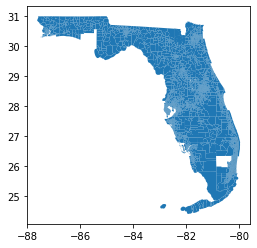

In [26]:
source_shapes = gp.GeoDataFrame(pd.concat(cleaned_fl_list))
two_sources = [source_shapes,census_block_precincts]
source_shapes_final = gp.GeoDataFrame(pd.concat(two_sources))
source_shapes_final.plot()
source_shapes_final = source_shapes_final.to_crs(vest_fl_16.crs)

#### Edit the merge column to join to election results

In [27]:
source_shapes_final.loc[:,"Precinct"]=source_shapes_final.loc[:,"Precinct"].astype(str)
source_shapes_final.loc[:,"Precinct"]=source_shapes_final.loc[:,"Precinct"].str.zfill(5)
source_shapes_final["countypct"]=source_shapes_final["County"]+source_shapes_final["Precinct"]

## Join election results to shapefiles

In [40]:
shapes_and_elections = pd.merge(source_shapes_final,pivoted_2016,on="countypct",how="outer",indicator=True)
#shapes_and_elections[shapes_and_elections["_merge"]=="left_only"].to_csv("./shapefile_only.csv")
#shapes_and_elections[shapes_and_elections["_merge"]=="right_only"].to_csv("./elections_only.csv")
both_shapes_and_elections = shapes_and_elections[shapes_and_elections["_merge"]=="both"]
print(shapes_and_elections["_merge"].value_counts())

both          5780
left_only      503
right_only     226
Name: _merge, dtype: int64


5780 precincts have both election results and shapefiles.  
503 precincts only have shapefiles  
226 precincts only have election results  

## Validation

### Join source file to VEST's final file

In [30]:
final_validation = pd.merge(both_shapes_and_elections,vest_fl_16,on="countypct",how="outer",indicator="final_ind")
print(final_validation["final_ind"].value_counts())
both = final_validation[final_validation["final_ind"]=="both"]

both          5779
right_only     221
left_only        1
Name: final_ind, dtype: int64


Of the 5780 precincts from the sourcefiles with election results and shapefiles, all but 1 of them joined to VEST.

### Validate Geometries

In [31]:
source_geoms = gp.GeoDataFrame(final_validation[final_validation["final_ind"]=="both"],geometry="geometry_x")
vest_geoms = gp.GeoDataFrame(final_validation[final_validation["final_ind"]=="both"],geometry="geometry_y")
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

False    4358
True     1421
dtype: int64


Of the 5779 precincts matched between the two files, 1421 matched geometry-wise, although that number appears low given the differences printed below.

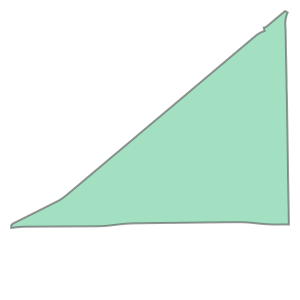

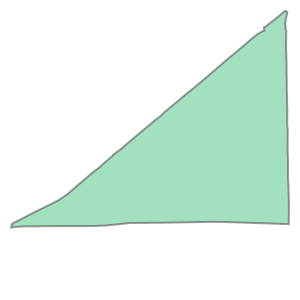

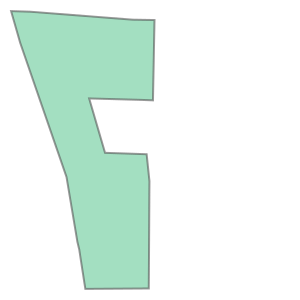

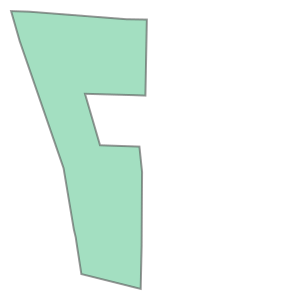

In [32]:
#Show a random difference
test = both[~vals].sample(axis=0,n=1).index[0]
display(both.iloc[test]["geometry_x"])
display(both.iloc[test]["geometry_y"])

#display(gp.overlay(both.iloc[test]["geometry_x"],both.iloc[test]["geometry_y"],how="overlap"))

test = both[~vals].sample(axis=0,n=1).index[0]
display(both.iloc[test]["geometry_x"])
display(both.iloc[test]["geometry_y"])

### Validate Election Results

#### Compare VEST election totals with source totals

The column totals do not match

In [37]:
#Checks the sums of different columns and prints out the 
def sum_checker (df1,df2, column_List):
    list_max = 0
    for i in column_List:
        df1_sum = df1[i].sum()
        df2_sum = df2[i].sum()
        if (df1_sum==df2_sum):
            print("Column: ", i, " have the same sums")
            
        else:
            diff = abs(df1_sum-df2_sum)
            percent = abs(df1_sum-df2_sum)/df1_sum
            print("Column: ", i)
            print("DataFrame #1 sum is ", str(df1_sum))
            print("DataFrame #2 sum is ", str(df2_sum))
            print("Their (absolute) difference is ",str(diff))
            print("As a percentage of DF1 this is ", str(round(percent,5)))
            if (percent>list_max):
                list_max = percent
            print("")
    print("The max difference (as a percent of the total of one DF column) is: ", str(round(list_max,5)))

In [39]:
col_list_totals = ["G16PRERTru","G16PREDCli","G16PRELJon","G16PRECCas","G16PREGSte","G16PREIDeL","G16PREoth","G16USSRRub","G16USSDMur","G16USSLSta","G16USSOth"]


sum_checker(pivoted_2016,vest_fl_16,col_list_totals)

Column:  G16PRERTru
DataFrame #1 sum is  4620979.0
DataFrame #2 sum is  4617347
Their (absolute) difference is  3632.0
As a percentage of DF1 this is  0.00079

Column:  G16PREDCli
DataFrame #1 sum is  4508731.0
DataFrame #2 sum is  4504158
Their (absolute) difference is  4573.0
As a percentage of DF1 this is  0.00101

Column:  G16PRELJon
DataFrame #1 sum is  207158.0
DataFrame #2 sum is  207007
Their (absolute) difference is  151.0
As a percentage of DF1 this is  0.00073

Column:  G16PRECCas
DataFrame #1 sum is  16488.0
DataFrame #2 sum is  16472
Their (absolute) difference is  16.0
As a percentage of DF1 this is  0.00097

Column:  G16PREGSte
DataFrame #1 sum is  64433.0
DataFrame #2 sum is  64385
Their (absolute) difference is  48.0
As a percentage of DF1 this is  0.00074

Column:  G16PREIDeL
DataFrame #1 sum is  9109.0
DataFrame #2 sum is  9107
Their (absolute) difference is  2.0
As a percentage of DF1 this is  0.00022

Column:  G16PREoth
DataFrame #1 sum is  77570.0
DataFrame #2 sum

Which counties have different vote totals for the "G16PREDCli" column

In [46]:
pd.set_option('display.max_rows', 70)
display(pivoted_2016.groupby(["county"]).sum()["G16PREDCli"]-vest_fl_16.groupby(["county"]).sum()["G16PREDCli"])

county
ALA       0.0
BAK       0.0
BAY       0.0
BRA       0.0
BRE       0.0
BRO       0.0
CAL       0.0
CHA       0.0
CIT       0.0
CLA       0.0
CLL      72.0
CLM       0.0
DAD       0.0
DES       0.0
DIX       0.0
DUV       0.0
ESC       0.0
FLA       9.0
FRA       0.0
GAD       0.0
GIL       0.0
GLA       0.0
GUL       0.0
HAM       0.0
HAR       0.0
HEN       0.0
HER       0.0
HIG       0.0
HIL       0.0
HOL       0.0
IND       0.0
JAC       0.0
JEF       0.0
LAF       0.0
LAK       5.0
LEE       0.0
LEO       0.0
LEV       0.0
LIB       0.0
MAD       0.0
MAN       0.0
MON       0.0
MRN       0.0
MRT       0.0
NAS       0.0
OKA       0.0
OKE       0.0
ORA       0.0
OSC      52.0
PAL    4435.0
PAS       0.0
PIN       0.0
POL       0.0
PUT       0.0
SAN       0.0
SAR       0.0
SEM       0.0
STJ       0.0
STL       0.0
SUM       0.0
SUW       0.0
TAY       0.0
UNI       0.0
VOL       0.0
WAK       0.0
WAL       0.0
WAS       0.0
Name: G16PREDCli, dtype: float64

#### Check election results (w/o shapefile data) against VEST file

In [35]:
check_election = pd.merge(vest_fl_16,pivoted_2016,how="outer",on="countypct",indicator=True)

print(check_election["_merge"].value_counts())
check_election[check_election["_merge"]=="left_only"].to_csv("./vest_election.csv")
check_election[check_election["_merge"]=="right_only"].to_csv("./source_election.csv")

both          5983
right_only      23
left_only       17
Name: _merge, dtype: int64


In [47]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff != 0):
                #print(df.iloc[j]['countypct'])
                #print(i)
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]['countypct'])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    print("New max diff is: ", str(max_diff))
                    print(df.iloc[j]['countypct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]['countypct'])
        else:
            matching_rows +=1
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 5")
    diff_list.sort()
    print(diff_list)

col_list = ["G16PRERTru","G16PREDCli","G16PRELJon","G16PRECCas","G16PREGSte","G16PREIDeL","G16PREoth","G16USSRRub","G16USSDMur","G16USSLSta"]


validater_row(check_election[check_election["_merge"]=="both"],col_list)


col_list_2 = ["G16PRERTru","G16PREDCli","G16PRELJon","G16PRECCas","G16PREGSte","G16PREIDeL","G16PREoth","G16USSRRub","G16USSDMur","G16USSLSta","G16USSOth"]

validater_row(check_election[check_election["_merge"]=="both"],col_list_2)

New max diff is:  683.0
SAR00429
New max diff is:  729.0
SAR00429
New max diff is:  1603.0
SAR00501
New max diff is:  1622.0
SAR00501
There are  5983  total rows
49  of these rows have election result differences
5934  of these rows are the same

The max difference between any one shared column in a row is:  1622.0
The average difference is:  122.72335025380711
There are  216 precinct results with a difference greater than 5
['HAR00005', 'HAR00008', 'HAR00011', 'HAR00012', 'PAL01173', 'PAL01189', 'PAL01247', 'PAL02081', 'PAL02083', 'PAL02097', 'PAL02116', 'PAL02126', 'PAL04129', 'PAL05003', 'PAL05007', 'PAL05018', 'PAL05055', 'PAL05112', 'PAL05113', 'PAL05115', 'PAL05117', 'PAL05119', 'PAL06207', 'PAL07149', 'PUT00014', 'PUT00015', 'PUT00016', 'PUT00018', 'PUT00019', 'PUT00020', 'PUT00021', 'PUT00022', 'PUT00023', 'PUT00024', 'PUT00025', 'PUT00026', 'PUT00027', 'PUT00028', 'PUT00030', 'PUT00032', 'PUT00033', 'PUT00036', 'PUT00037', 'SAR00429', 'SAR00501', 'WAL00430', 'WAL00440', 'WAL00

The first print above includes the Senate Other column, the second does not